[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/simple_detector_v1.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip -d ./data/RTSD
    !rm rtsd-dataset.zip
    !cp -r data/RTSD/rtsd-frames/rtsd-frames/ data/RTSD/
    !rm -r data/RTSD/rtsd-frames/rtsd-frames/
    !pip install fiftyone

dataset_path = 'data/RTSD'

In [2]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2

## Обучение модели

In [ ]:

# define the torchvision image transforms
#transform = transforms.Compose([
#    transforms.ToTensor(),
#])

In [3]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2
#PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

In [ ]:
#from PIL import Image
#img = Image.open('data/rtsd-frames/autosave01_02_2012_09_16_49.jpg').convert("RGB")
#img

### Загрузчик данных

In [3]:
class RTSD_dataset(Dataset):
  
    def __init__(self, json_path, img_path):
        self.json_path = json_path
        self.img_path = img_path
        
        with open(json_path, 'r') as read_file:
            self.anno = json.load(read_file)
        read_file.close()

        self.df_dataset = pd.DataFrame(self.anno.get('annotations'))
        self.test = self.df_dataset.copy()
        #self.test['bbox_for_rcnn'] = self.test.bbox[0]
        self.df_images = pd.DataFrame(self.anno.get('images'))
        self.df_images.rename(columns={'id':'image_id'}, inplace=True)
        self.df_dataset = self.df_dataset.merge(self.df_images)
        self.df_dataset = self.df_dataset[['file_name', 'bbox', 'category_id']].groupby('file_name', as_index=False).agg(list)

    def get_df(self):
        #return self.df_dataset
        return self.test

    def __len__(self):
        return self.df_dataset.shape[0]
  
    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'file_name']
        boxes = []
        for box in self.df_dataset.loc[index,'bbox']:
            box_for_rcnn = [box[0], box[1], box[0] + box[2], box[1] + box[3]]
            boxes.append(box_for_rcnn)
        boxes = torch.Tensor(boxes).to(torch.float)            # возможно нужно преобразовать x_max и y_max
        #boxes = torch.Tensor(self.df_dataset.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df_dataset.loc[index, 'category_id']).to(torch.int64)
        #area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        #iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        #return img, target
        return img, target

In [4]:
test = RTSD_dataset('data/train_anno_reduced.json', 'data/')
test.__getitem__(9)

(tensor([[[0.4902, 0.5255, 0.5255,  ..., 0.8863, 0.8824, 0.9412],
          [0.5294, 0.4902, 0.4784,  ..., 0.8549, 0.8667, 0.9294],
          [0.5765, 0.5059, 0.4745,  ..., 0.8000, 0.8353, 0.8941],
          ...,
          [0.2118, 0.2039, 0.2039,  ..., 0.4000, 0.4000, 0.3961],
          [0.2157, 0.2157, 0.2118,  ..., 0.3882, 0.3922, 0.3922],
          [0.0980, 0.0980, 0.0863,  ..., 0.1451, 0.1529, 0.1529]],
 
         [[0.2353, 0.2706, 0.2824,  ..., 0.6196, 0.5686, 0.6039],
          [0.2667, 0.2275, 0.2275,  ..., 0.5922, 0.5647, 0.6078],
          [0.2980, 0.2314, 0.2078,  ..., 0.5412, 0.5569, 0.6118],
          ...,
          [0.1412, 0.1412, 0.1412,  ..., 0.2275, 0.2235, 0.2235],
          [0.1529, 0.1529, 0.1490,  ..., 0.2627, 0.2549, 0.2588],
          [0.0353, 0.0353, 0.0314,  ..., 0.0431, 0.0392, 0.0392]],
 
         [[0.0824, 0.1176, 0.1216,  ..., 0.0824, 0.1020, 0.1647],
          [0.1137, 0.0745, 0.0667,  ..., 0.1020, 0.1059, 0.1686],
          [0.1490, 0.0745, 0.0392,  ...,

### Формирование батча

In [5]:
del test

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Гиперпараметры

In [7]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'
n_epochs = 10
batch_size = 8
num_classes = 156

device

'cuda:0'

### Инициализация модели, задание оптимизатора и функции потерь

In [8]:
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [18]:
model = create_model(num_classes=156, pretrained=True).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#ptimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

### Трейн луп

In [16]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader} на обучающей выборке. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    len_dataloader = len(val_dataloader)
    running_loss = 0
    for i, data in enumerate(val_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader} на тестовой выборке. Loss: {loss}")
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [10]:
checkpoints_path = 'checkpoints'
model_name = 'resnet50_all_classes'

In [20]:
train_losses = []
val_losses = []
try:
    for epoch in range(10):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                'losses_train': train_losses,
                'losses_val': val_losses,
                }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_classifier_{model_name}_{epoch}.pth'))

except KeyboardInterrupt:
    print('Прервано пользователем')

    

	Эпоха 0. Итерация 0/6774 на обучающей выборке. Loss: 5.114344120025635
	Эпоха 0. Итерация 50/6774 на обучающей выборке. Loss: 0.4196016788482666
	Эпоха 0. Итерация 100/6774 на обучающей выборке. Loss: 0.4057539701461792
	Эпоха 0. Итерация 150/6774 на обучающей выборке. Loss: 0.48869940638542175
	Эпоха 0. Итерация 200/6774 на обучающей выборке. Loss: 0.24875342845916748
	Эпоха 0. Итерация 250/6774 на обучающей выборке. Loss: 0.3601597249507904
	Эпоха 0. Итерация 300/6774 на обучающей выборке. Loss: 0.3340436518192291
	Эпоха 0. Итерация 350/6774 на обучающей выборке. Loss: 0.3451211452484131
	Эпоха 0. Итерация 400/6774 на обучающей выборке. Loss: 0.3485730290412903
	Эпоха 0. Итерация 450/6774 на обучающей выборке. Loss: 0.26979395747184753
	Эпоха 0. Итерация 500/6774 на обучающей выборке. Loss: 0.2767212390899658
	Эпоха 0. Итерация 550/6774 на обучающей выборке. Loss: 0.46090176701545715
	Эпоха 0. Итерация 600/6774 на обучающей выборке. Loss: 0.22132660448551178
	Эпоха 0. Итерация 650/6

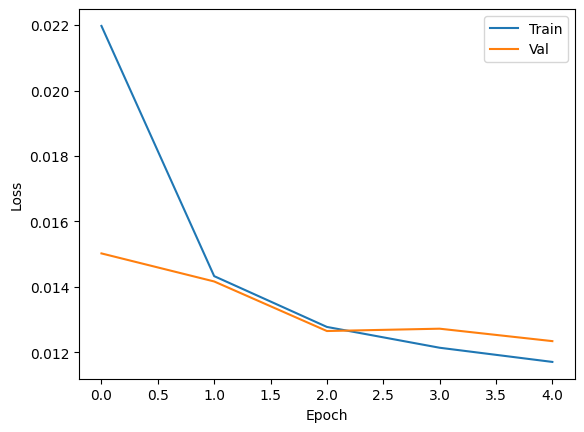

In [23]:
%matplotlib inline
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()